In [2]:
import os
import numpy as np
import torch
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from itertools import cycle
from transformers import AutoProcessor, AutoModel
import seaborn as sns
import pandas as pd

Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Data shapes:
X_train: (1600, 128, 128, 2, 1)
BioViL features: (1600, 10, 768)
Labels: (1600,)


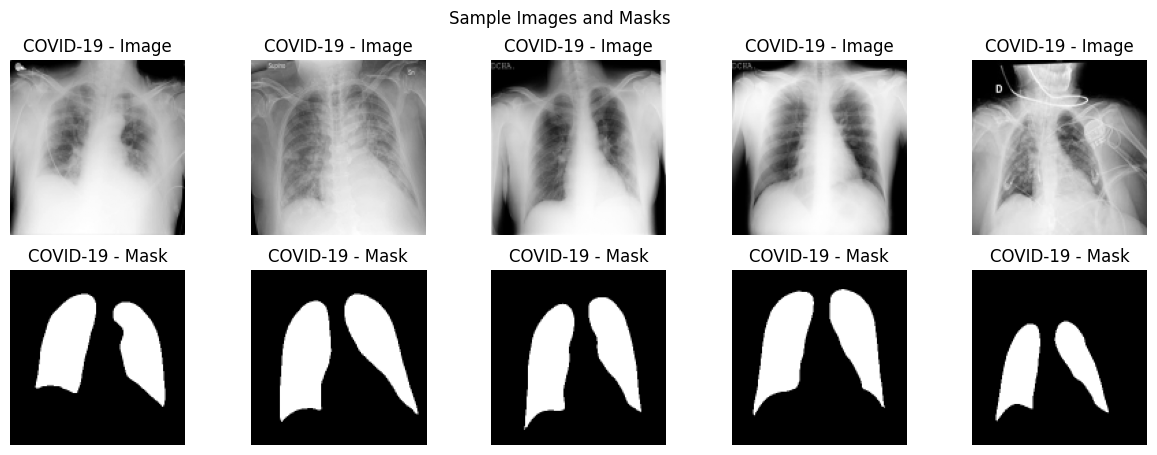

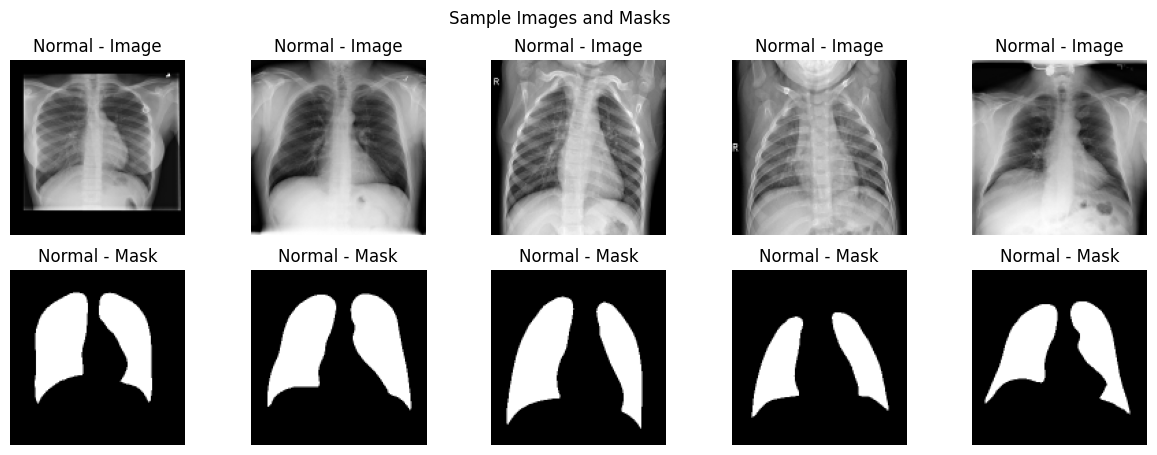

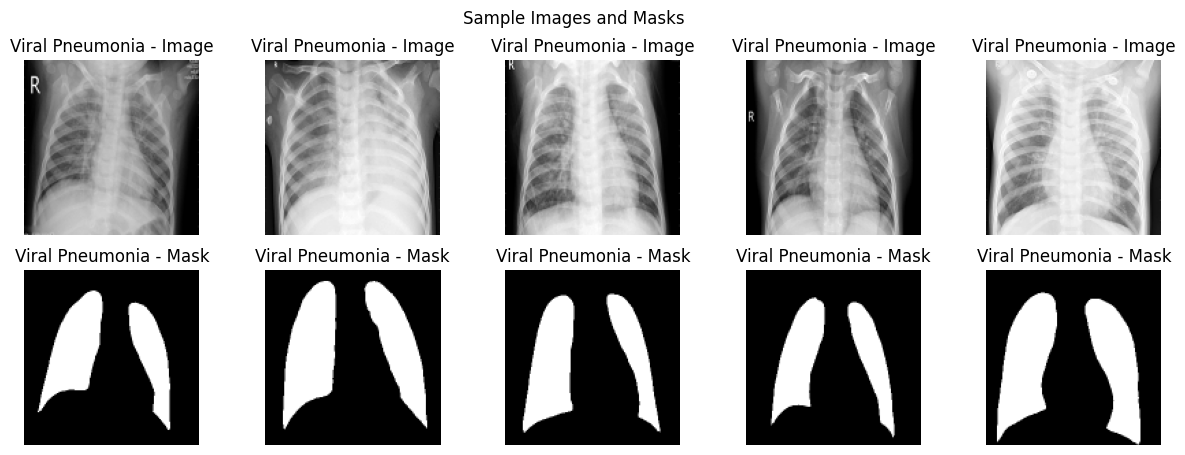

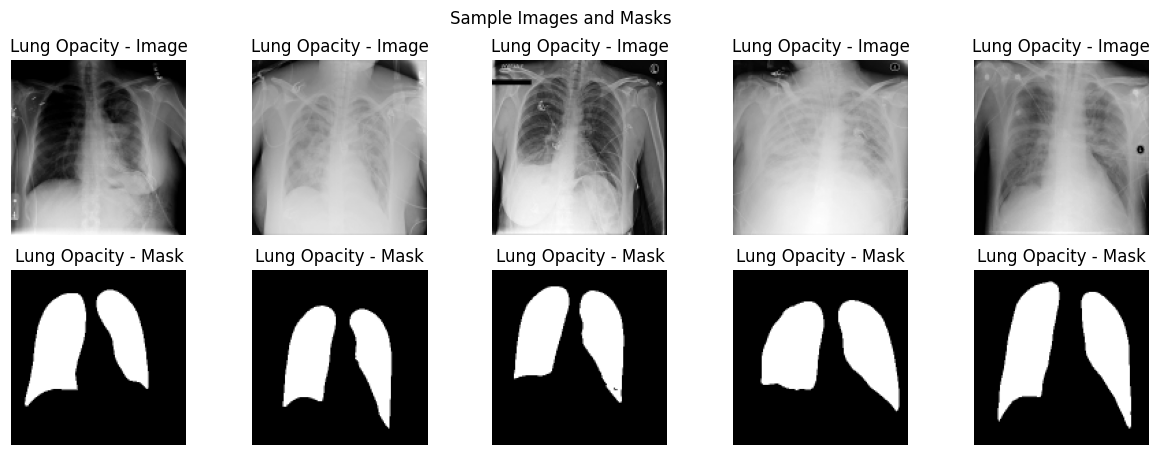

/opt/anaconda3/envs/r_new/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.3731 - loss: 1.3417 - val_accuracy: 0.6469 - val_loss: 0.8258
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.6633 - loss: 0.8181 - val_accuracy: 0.7219 - val_loss: 0.6629
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.7368 - loss: 0.6646 - val_accuracy: 0.7719 - val_loss: 0.5328
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7912 - loss: 0.5235 - val_accuracy: 0.7719 - val_loss: 0.5647
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.8004 - loss: 0.4919 - val_accuracy: 0.8062 - val_loss: 0.5064
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.8573 - loss: 0.4010 - val_accuracy: 0.8094 - val_loss: 0.4615
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.8695 - loss: 0.3475 - val_accuracy: 0.8031 - val_loss: 0.4704
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8819 - loss: 0.3152 - val_accuracy: 0.

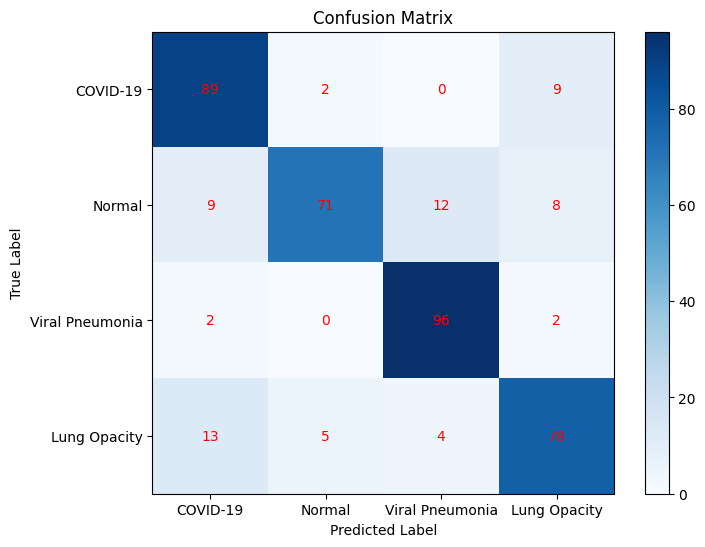

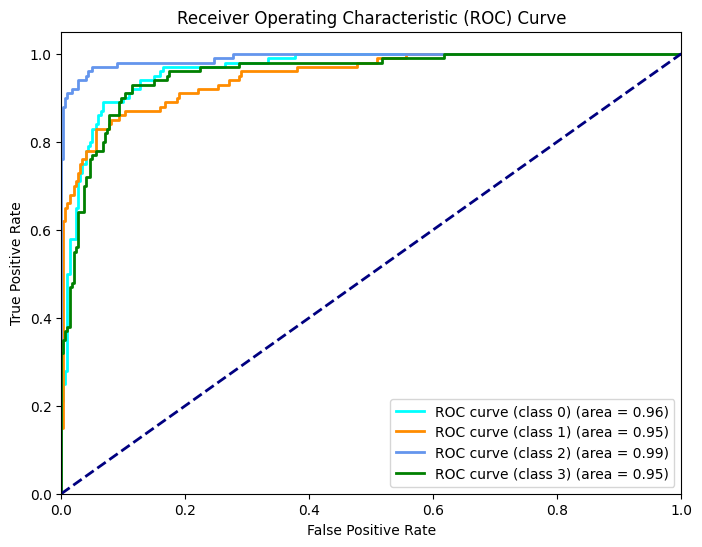

In [4]:

# for Suppress  the TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Loading the BioViL-T processor and model
biovil_processor = AutoProcessor.from_pretrained("microsoft/BiomedVLP-BioViL-T", trust_remote_code=True)
biovil_model = AutoModel.from_pretrained("microsoft/BiomedVLP-BioViL-T", trust_remote_code=True)

# Function to extract BioViL image embedding
def get_biovil_embedding(img_path, img_size=(128, 128)):
    # Loading and preprocess the image
    img = image.load_img(img_path, target_size=img_size, color_mode="rgb")
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]

    # text defining for corresponding image for Biovil
    if "COVID" in img_path:
        text = "This is a COVID CT-SCAN"
    elif "Normal" in img_path:
        text = "This is a Normal CT-SCAN"
    elif "Viral Pneumonia" in img_path:
        text = "This is a Viral Pneumonia CT-SCAN"
    elif "Lung_Opacity" in img_path:
        text = "This is a Lung Opacity CT-SCAN"
    else:
        text = "Unknown label"

    # Processing the text
    text_inputs = biovil_processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Convert image to tensor with batch size and correct dimensions
    img_tensor = torch.tensor(img_array).permute(2, 0, 1).unsqueeze(0).float()  

    # output from BioViL-T model
    with torch.no_grad():
        outputs = biovil_model(input_ids=text_inputs['input_ids'], 
                               attention_mask=text_inputs['attention_mask'], 
                               pixel_values=img_tensor)

    # Extracting the 'last_hidden_state' as the image embedding
    if 'last_hidden_state' in outputs:
        img_embedding = outputs.last_hidden_state.squeeze(0)  
    else:
        print(f"Skipping {img_path}: Image embedding not found in BioViL output.")
        return None

    return img_embedding.numpy()

# Function to load and preprocess images, masks, and BioViL features
def load_images_and_masks_with_biovil(image_folder, mask_folder, label, img_size=(128, 128), sample_size=500):
    images, embeddings, labels = [], [], []
    files = sorted(os.listdir(image_folder))[:sample_size]

    for filename in files:
        img_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)

        # Skiping if mask  for respective image is not found
        if not os.path.exists(mask_path):
            print(f"Skipping {filename}: mask not found")
            continue

        # Extract BioViL embedding
        embedding = get_biovil_embedding(img_path, img_size)
        if embedding is None:
            continue

        # Loading grayscale image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        img = img / 255.0

        # Loading mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0

        # Stack image and mask as two channels
        stacked = np.stack((img, mask), axis=-1) 

        images.append(stacked)
        embeddings.append(embedding)
        labels.append(label)

    return np.array(images), np.array(embeddings), np.array(labels)

# Dataset paths
dataset_path = r"/Users/sahitya_gantala/Downloads/COVID-19_Radiography_Dataset"
covid_images_path = os.path.join(dataset_path, "COVID", "images")
covid_masks_path = os.path.join(dataset_path, "COVID", "masks")
normal_images_path = os.path.join(dataset_path, "Normal", "images")
normal_masks_path = os.path.join(dataset_path, "Normal", "masks")
viral_images_path = os.path.join(dataset_path, "Viral Pneumonia", "images")
viral_masks_path = os.path.join(dataset_path, "Viral Pneumonia", "masks")
opacity_images_path = os.path.join(dataset_path, "Lung_Opacity", "images")
opacity_masks_path = os.path.join(dataset_path, "Lung_Opacity", "masks")

# Load all categories
X_covid, biovil_covid, y_covid = load_images_and_masks_with_biovil(covid_images_path, covid_masks_path, label=0, sample_size=500)
X_normal, biovil_normal, y_normal = load_images_and_masks_with_biovil(normal_images_path, normal_masks_path, label=1, sample_size=500)
X_viral, biovil_viral, y_viral = load_images_and_masks_with_biovil(viral_images_path, viral_masks_path, label=2, sample_size=500)
X_opacity, biovil_opacity, y_opacity = load_images_and_masks_with_biovil(opacity_images_path, opacity_masks_path, label=3, sample_size=500)

X_all = np.concatenate([X_covid, X_normal, X_viral, X_opacity], axis=0)
biovil_all = np.concatenate([biovil_covid, biovil_normal, biovil_viral, biovil_opacity], axis=0)
y_all = np.concatenate([y_covid, y_normal, y_viral, y_opacity], axis=0)

# Add channel dimension to images
X_all = X_all[..., np.newaxis]

# Split the data 
X_train, X_test, X_biovil_train, X_biovil_test, y_train, y_test = train_test_split(
    X_all, biovil_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print("Data shapes:")
print("X_train:", X_train.shape)
print("BioViL features:", X_biovil_train.shape)
print("Labels:", y_train.shape)

# Displaying few images and masks to confirm successful loading
def display_samples(images, masks, titles, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Image display
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i][:, :, 0], cmap='gray')
        plt.title(f"{titles[i]} - Image")
        plt.axis('off')

        # Mask display
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(masks[i][:, :, 1], cmap='gray')
        plt.title(f"{titles[i]} - Mask")
        plt.axis('off')
    plt.suptitle("Sample Images and Masks")
    plt.show()

# Displaying samples from each category
display_samples(X_covid, X_covid, ["COVID-19"] * 5)
display_samples(X_normal, X_normal, ["Normal"] * 5)
display_samples(X_viral, X_viral, ["Viral Pneumonia"] * 5)
display_samples(X_opacity, X_opacity, ["Lung Opacity"] * 5)
# Convert labels to categorical
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 2)),  # 2 channels: image + mask
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
CNN_Model = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Prediction on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Printing the Classification metrics
print("\n--- Classification Report ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(num_classes), ["COVID-19", "Normal", "Viral Pneumonia", "Lung Opacity"])
plt.yticks(np.arange(num_classes), ["COVID-19", "Normal", "Viral Pneumonia", "Lung Opacity"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="red")
plt.show()

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_classes == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve (class {i}) (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [5]:
# Evaluating robustness
def apply_perturbation_batch(images, mode="noise"):
    perturbed_images = []
    for img in images:
        img = img.squeeze(-1)  
        if mode == "noise":
            noise = np.random.normal(0, 0.1, img.shape)
            img_p = np.clip(img + noise, 0, 1)
        elif mode == "blur":
            img_p = cv2.GaussianBlur(img, (5, 5), 0)
        elif mode == "brightness":
            img_p = np.clip(img * 1.5, 0, 1)
        else:
            img_p = img
        perturbed_images.append(img_p[..., np.newaxis]) 
    return np.array(perturbed_images)
perturbations = ["clean", "noise", "blur", "brightness"]
for mode in perturbations:
    X_eval = X_test if mode == "clean" else apply_perturbation_batch(X_test, mode)
    y_pred_mode = model.predict(X_eval)
    y_pred_mode_labels = np.argmax(y_pred_mode, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true_labels, y_pred_mode_labels)
    print(f"Accuracy under {mode}: {acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy under clean: 0.8350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy under noise: 0.8025
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy under blur: 0.7650
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy under brightness: 0.7650


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample indices with highest variance (uncertainty): [240 209  33 268 142]
Sample indices with lowest variance (confidence): [154 273 338  77 336]


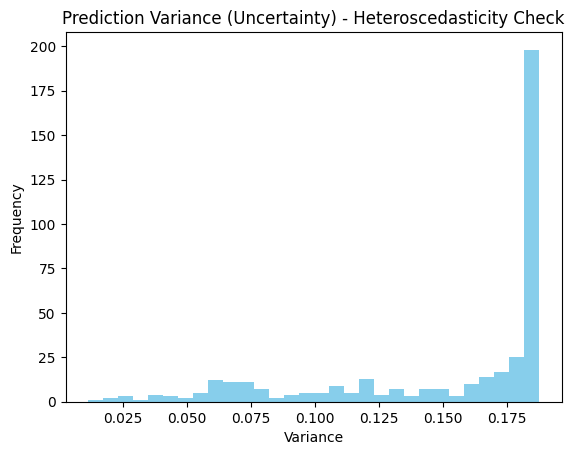

In [6]:
# Heteroscedasticity Analysis
pred_probs = model.predict(X_test)
variances = np.var(pred_probs, axis=1)

# Analyze high vs low variance
high_var_indices = np.argsort(variances)[-5:]
low_var_indices = np.argsort(variances)[:5]

print("Sample indices with highest variance (uncertainty):", high_var_indices)
print("Sample indices with lowest variance (confidence):", low_var_indices)

plt.hist(variances, bins=30, color='skyblue')
plt.title("Prediction Variance (Uncertainty) - Heteroscedasticity Check")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()


Training with 10% of data → Val Loss: 0.8667
Training with 20% of data → Val Loss: 0.8580
Training with 40% of data → Val Loss: 0.6815
Training with 60% of data → Val Loss: 0.5372
Training with 80% of data → Val Loss: 0.5719


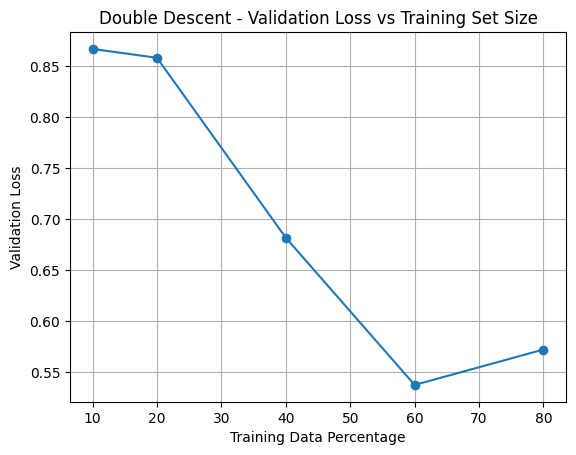

In [7]:
# Double Descent Curve 
sample_sizes = [10, 20, 40, 60, 80]  

val_losses = []
for pct in sample_sizes:
    idx = np.random.choice(len(X_train), int(len(X_train)*pct/100), replace=False)
    X_sub, y_sub = X_train[idx], y_train[idx]
    
    model_dd = tf.keras.models.clone_model(model)
    model_dd.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    hist = model_dd.fit(X_sub, y_sub, epochs=5, validation_data=(X_test, y_test), verbose=0)
    val_losses.append(hist.history['val_loss'][-1])
    print(f"Training with {pct}% of data → Val Loss: {val_losses[-1]:.4f}")
plt.plot(sample_sizes, val_losses, marker='o')
plt.title("Double Descent - Validation Loss vs Training Set Size")
plt.xlabel("Training Data Percentage")
plt.ylabel("Validation Loss")
plt.grid(True)
plt.show()


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.3027 - loss: 1.5274 - val_accuracy: 0.5469 - val_loss: 0.9649
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5838 - loss: 0.9619 - val_accuracy: 0.6750 - val_loss: 0.7231
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7072 - loss: 0.7243 - val_accuracy: 0.7531 - val_loss: 0.6514
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7131 - loss: 0.7054 - val_accuracy: 0.7563 - val_loss: 0.6135
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.7146 - loss: 0.6701 - val_accuracy: 0.7156 - val_loss: 0.7920
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.7476 - loss: 0.6232 - val_accuracy: 0.7875 - val_loss: 0.5331
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7706 - loss: 0.5449 - val_accuracy: 0.7937 - val_loss: 0.5207
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8008 - loss: 0.4765 - val_accuracy: 0.

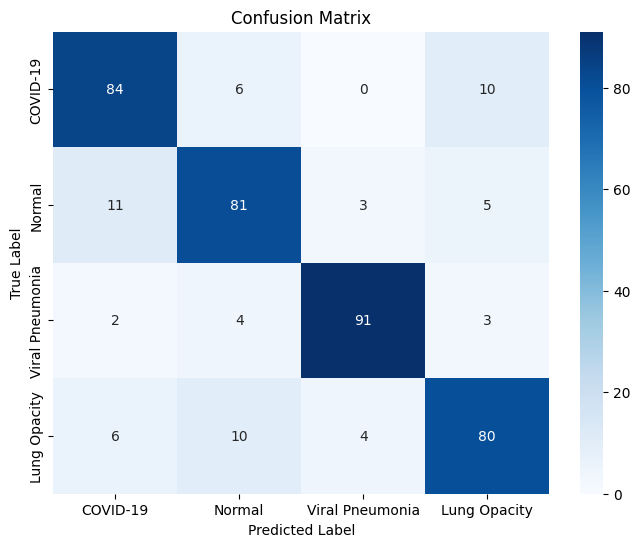

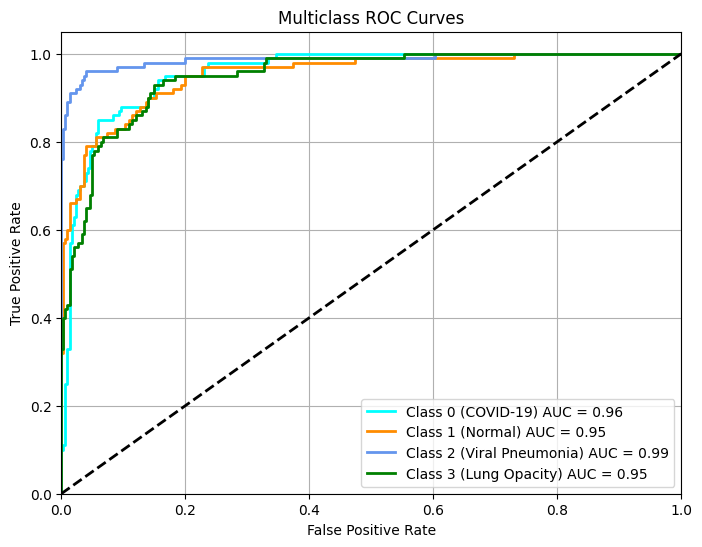

In [8]:
# CNN+BIOVIL 
# CNN Path (Image + Mask)
img_input = Input(shape=(128, 128, 2), name="image_input")
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# BioViL Path
biovil_input = Input(shape=(10, 768), name="biovil_input")  
y = Flatten()(biovil_input)
y = Dense(128, activation='relu')(y)
y = Dropout(0.5)(y)

# Combine both paths
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(num_classes, activation='softmax')(z)

# Final model
dual_model = Model(inputs=[img_input, biovil_input], outputs=z)

# Compile the model
dual_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
CNNBIO_model = dual_model.fit(
    [X_train.squeeze(-1), X_biovil_train],  # remove last dim (1) from X_train if needed
    y_train,
    epochs=15,
    validation_split=0.2
)


# Prediction on the test
y_pred = dual_model.predict([X_test, X_biovil_test])
y_pred_classes_BI = np.argmax(y_pred, axis=1)
y_true_classes_BI = np.argmax(y_test, axis=1)

# Classification metrics
acc = accuracy_score(y_true_classes_BI, y_pred_classes_BI)
prec = precision_score(y_true_classes_BI, y_pred_classes_BI, average='weighted')
rec = recall_score(y_true_classes_BI, y_pred_classes_BI, average='weighted')
f1 = f1_score(y_true_classes_BI, y_pred_classes_BI, average='weighted')

# Printing the Classification metrics
print("\n--- Classification Report ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting the Classification metrics
conf_matrix = confusion_matrix(y_true_classes_BI, y_pred_classes_BI)
class_names = ["COVID-19", "Normal", "Viral Pneumonia", "Lung Opacity"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotting ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = y_test.shape[1]

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} ({class_names[i]}) AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [9]:
# Evaluating robustness
def apply_perturbation_batch(images, mode="noise"):
    perturbed = []
    for img in images:
        if mode == "noise":
            noise = np.random.normal(0, 0.1, img.shape)
            img_p = np.clip(img + noise, 0, 1)
        elif mode == "blur":
            img_p = np.zeros_like(img)
            for c in range(img.shape[-1]):
                img_p[..., c] = cv2.GaussianBlur(img[..., c], (5, 5), 0)
        elif mode == "brightness":
            img_p = np.clip(img * 1.5, 0, 1)
        else:
            img_p = img
        perturbed.append(img_p)
    return np.array(perturbed)

perturb_modes = ["clean", "noise", "blur", "brightness"]
print("\n--- OOD Robustness ---")
for mode in perturb_modes:
    X_eval = X_test if mode == "clean" else apply_perturbation_batch(X_test, mode)
    y_pred_dual = dual_model.predict([X_eval, X_biovil_test[:X_eval.shape[0]]])
    y_pred_classes = np.argmax(y_pred_dual, axis=1)
    y_true_classes = np.argmax(y_test[:X_eval.shape[0]], axis=1)

    acc = accuracy_score(y_true_classes, y_pred_classes)
    print(f"Accuracy under {mode}: {acc:.4f}")



--- OOD Robustness ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy under clean: 0.8400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy under noise: 0.8100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy under blur: 0.7950
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy under brightness: 0.8100


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample indices with highest variance (uncertainty): [240 209  33 268 142]
Sample indices with lowest variance (confidence): [274 104  41 213 351]


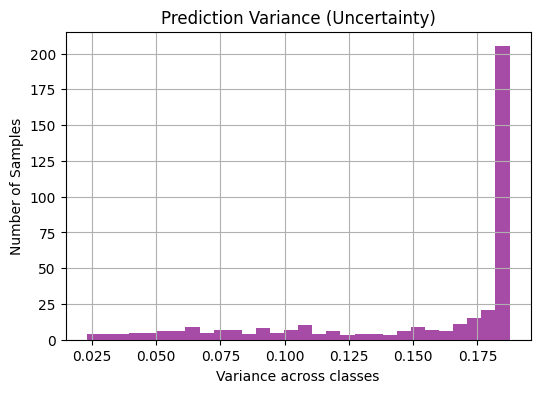

In [10]:
# Heteroscedasticity Analysis
y_pred_proba = dual_model.predict([X_test, X_biovil_test])
variances = np.var(y_pred_proba, axis=1)

high_var_ids = np.argsort(variances)[-5:]
low_var_indices = np.argsort(variances)[:5]

print("Sample indices with highest variance (uncertainty):", high_var_indices)
print("Sample indices with lowest variance (confidence):", low_var_indices)

plt.figure(figsize=(6, 4))
plt.hist(variances, bins=30, color='purple', alpha=0.7)
plt.title("Prediction Variance (Uncertainty)")
plt.xlabel("Variance across classes")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


Training with 10% data → Val Loss: 1.3096
Training with 20% data → Val Loss: 0.8751
Training with 40% data → Val Loss: 0.7295
Training with 60% data → Val Loss: 0.5418
Training with 80% data → Val Loss: 0.4617


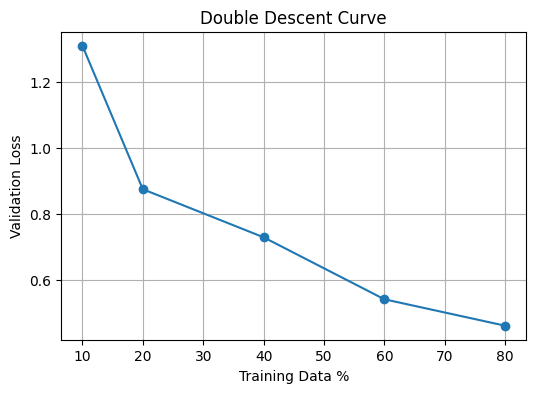

In [11]:
# Double Descent Curve 
sample_percents = [10, 20, 40, 60, 80]
val_losses = []

for pct in sample_percents:
    num_samples = int(len(X_train) * pct / 100)
    idx = np.random.choice(len(X_train), num_samples, replace=False)

    X_sub = X_train[idx]
    X_biovil_sub = X_biovil_train[idx]
    y_sub = y_train[idx]

    model_temp = tf.keras.models.clone_model(dual_model)
    model_temp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    hist = model_temp.fit(
        [X_sub, X_biovil_sub], y_sub,
        epochs=5, validation_data=([X_test, X_biovil_test], y_test),
        verbose=0
    )

    val_loss = hist.history['val_loss'][-1]
    val_losses.append(val_loss)
    print(f"Training with {pct}% data → Val Loss: {val_loss:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(sample_percents, val_losses, marker='o')
plt.title("Double Descent Curve")
plt.xlabel("Training Data %")
plt.ylabel("Validation Loss")
plt.grid(True)
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

=== Model Performance Comparison ===
              Accuracy  Precision  Recall  F1 Score
CNN Only          0.81   0.813054    0.81  0.809421
CNN + BioViL      0.84   0.840603    0.84  0.840207


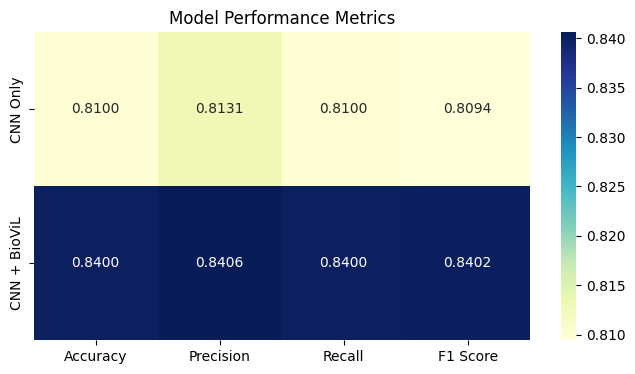

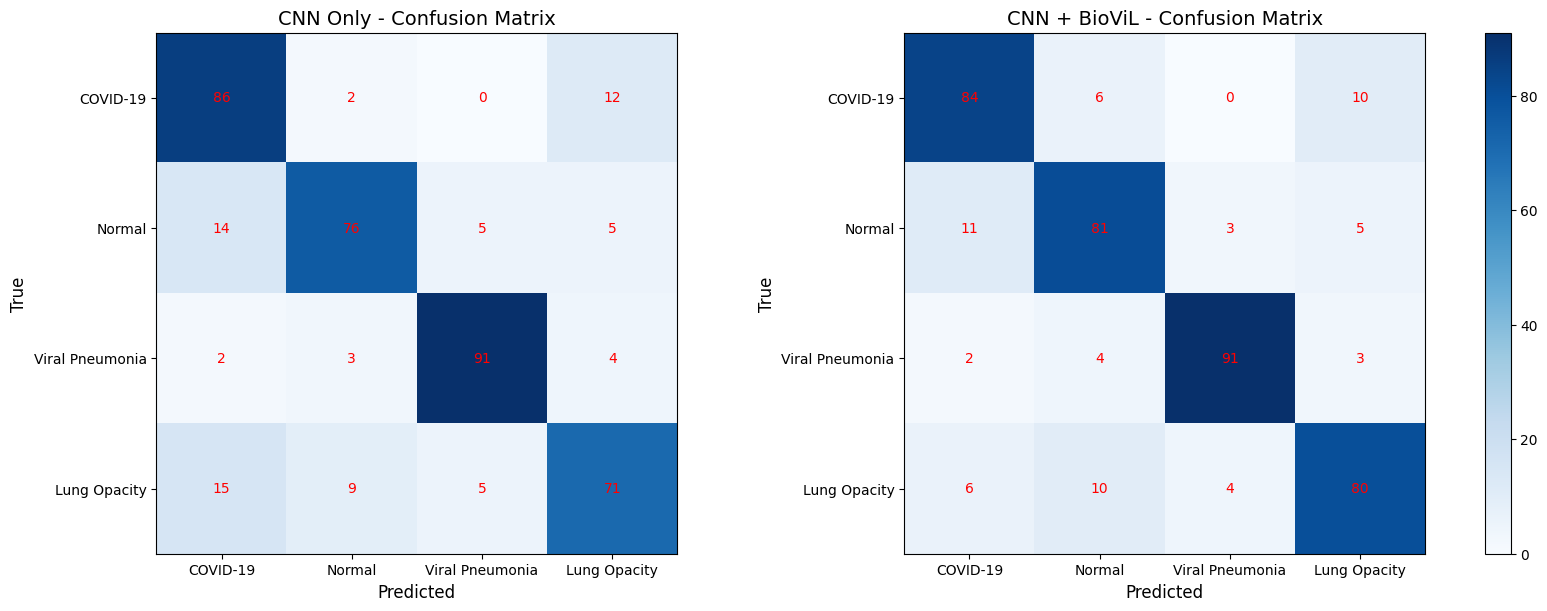

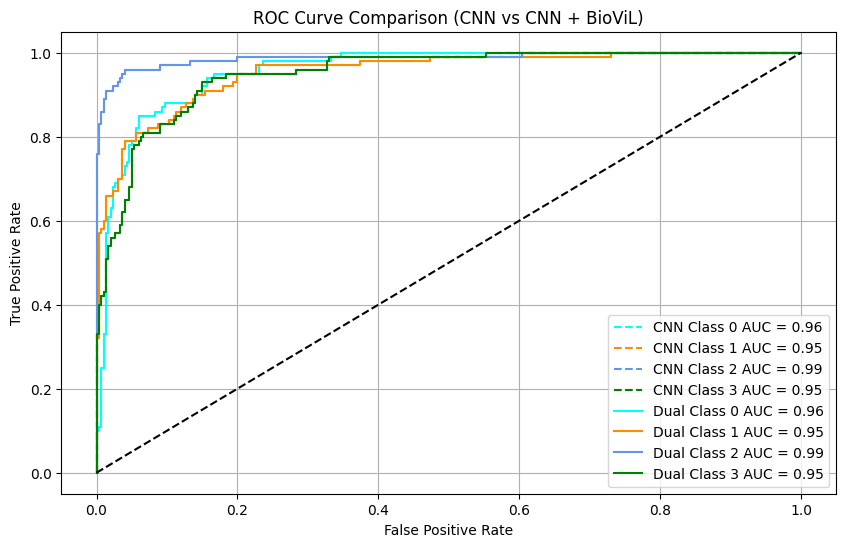

In [15]:
# Comparison between the model.
# Step 1: Evaluate CNN-only model
cnn_metrics = {
    "Accuracy": accuracy_score(y_true_classes, y_pred_classes),
    "Precision": precision_score(y_true_classes, y_pred_classes, average='weighted'),
    "Recall": recall_score(y_true_classes, y_pred_classes, average='weighted'),
    "F1 Score": f1_score(y_true_classes, y_pred_classes, average='weighted')
}

cnn_conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
cnn_roc = [roc_curve(y_true_classes == i, y_pred[:, i]) for i in range(num_classes)]
cnn_auc = [auc(fpr, tpr) for fpr, tpr, _ in cnn_roc]

# Step 2: Evaluate Dual Model
dual_metrics = {
    "Accuracy": accuracy_score(y_true_classes_BI, y_pred_classes_BI),
    "Precision": precision_score(y_true_classes_BI, y_pred_classes_BI, average='weighted'),
    "Recall": recall_score(y_true_classes_BI, y_pred_classes_BI, average='weighted'),
    "F1 Score": f1_score(y_true_classes_BI, y_pred_classes_BI, average='weighted')
}

dual_conf_matrix = confusion_matrix(y_true_classes_BI, y_pred_classes_BI)
dual_pred = dual_model.predict([X_test, X_biovil_test])
dual_roc = [roc_curve(y_true_classes_BI == i, dual_pred[:, i]) for i in range(num_classes)]
dual_auc = [auc(fpr, tpr) for fpr, tpr, _ in dual_roc]

# Step 3: Print Comparison Table
comparison_df = pd.DataFrame([cnn_metrics, dual_metrics], index=["CNN Only", "CNN + BioViL"])
print("\n=== Model Performance Comparison ===")
print(comparison_df)

# Step 4: Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(comparison_df, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Model Performance Metrics")
plt.show()

# Step 5: Side-by-side Confusion Matrices 
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

class_labels = ["COVID-19", "Normal", "Viral Pneumonia", "Lung Opacity"]

for idx, (matrix, title) in enumerate([
    (cnn_conf_matrix, "CNN Only - Confusion Matrix"),
    (dual_conf_matrix, "CNN + BioViL - Confusion Matrix")
]):
    ax = axes[idx]
    im = ax.imshow(matrix, cmap='Blues')
    ax.set_title(title, fontsize=14)
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("True", fontsize=12)


    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, matrix[i, j], ha="center", va="center", color="red", fontsize=10)

# Add one shared colorbar for both
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
plt.show()


# Step 6: ROC Curve Comparison
plt.figure(figsize=(10, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

# CNN ROC
for i, color in zip(range(num_classes), colors):
    fpr, tpr, _ = cnn_roc[i]
    plt.plot(fpr, tpr, linestyle='--', color=color, label=f"CNN Class {i} AUC = {cnn_auc[i]:.2f}")

# Dual ROC
for i, color in zip(range(num_classes), colors):
    fpr, tpr, _ = dual_roc[i]
    plt.plot(fpr, tpr, linestyle='-', color=color, label=f"Dual Class {i} AUC = {dual_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (CNN vs CNN + BioViL)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
